# Minecraft Agent - Deep Reinforcement

Work realised in collaboration with:

- [Clément Romac](https://github.com/ClementRomac)
- [Pierre Leroy](https://github.com/PierreLeroyBdx)

Inspired by the work of [Arthur Juliani](https://github.com/awjuliani/DeepRL-Agents) and the [Malmo Project](https://github.com/Microsoft/malmo).
Thanks to [Gym Minecraft](https://github.com/tambetm/gym-minecraft) & [Tensorflow](https://www.tensorflow.org/)

In [30]:
import gym
import gym_minecraft
import numpy as np
import tensorflow as tf
import math
import random
import time
import datetime
import pickle
from enum import Enum
import matplotlib.pyplot as plt
from lxml import etree
import logging

## Envrionnemental Settings

The frame size is a useful variable, it allows us to decide which size our inputs are going to be.
The values are very important, wider your frame will be and longer the training session is going to be, however you'll give more information to your network.

In [31]:
graph1 = tf.Graph()
frame_size = [60,60]
num_input = frame_size[0] * frame_size[1]

In [32]:
env = gym.make('MinecraftBasic-v0')  
env.init(start_minecraft = True, 
         videoResolution = [frame_size[0], frame_size[1]], 
         allowDiscreteMovement = ["move", "turn"],
         step_sleep = 0.25,
         skip_steps = 0) #Movements modified to a faster convergence

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.


## Neural Networks

### Neural Net Definition 1 (Convolutional)

In [33]:
class Convolutional():
    def __init__(self):
        self.x = tf.placeholder("float", [None, num_input])

        #Reshape the flatten data
        self.input_layer = tf.reshape(self.x, [-1, frame_size[1], frame_size[0], 1])
    
        #Convolutional Layer 1
        self.conv1 = tf.layers.conv2d(
            inputs = self.input_layer,
            filters = 32,
            kernel_size = [6, 6],
            strides=[2, 2],
            padding = "valid",
            activation = tf.nn.relu)
        #Output size = 28

        #Convolutional Layer 2
        self.conv2 = tf.layers.conv2d(
            inputs = self.conv1,
            filters = 64,           
            kernel_size = [6, 6],
            strides = [2, 2],
            padding = "valid",
            activation = tf.nn.relu)
        #Output size = 12

        #Convolutional Layer 3
        self.conv3 = tf.layers.conv2d(
            inputs = self.conv2,
            filters = 64,
            kernel_size = [4, 4],
            strides = [2, 2],
            padding = "valid",
            activation = tf.nn.relu)
        #Output size = 5

        #Flatten the data to pass it through the feed forward
        self.dims = self.conv3.get_shape().as_list()
        self.final_dimension = self.dims[1] * self.dims[2] * self.dims[3]
        self.conv3_flat = tf.reshape(self.conv3, [-1, self.final_dimension])
        
        #Feed Forward
        self.dense = tf.layers.dense(inputs = self.conv3_flat, units = 512, activation = tf.nn.relu)
        
        self.Qout = tf.layers.dense(inputs = self.dense, units = num_classes)
        
        #Indexes of the actions the network shall take
        self.prediction = tf.argmax(self.Qout, 1)
        
        self.actions = tf.placeholder(shape = [None], dtype = tf.int32)
        #Multiply our Q-values by a OneHotEncoding to only take the chosen ones.
        self.actions_onehot = tf.one_hot(self.actions, num_classes, dtype = tf.float32)
        #So that Q's going to be the Q-values calculated by the Target network
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis = 1)

        #NextQ corresponds to the Q estimated by the Bellman Equation
        self.nextQ = tf.placeholder(shape = [None], dtype = tf.float32)
                
        #The loss value coresponds to the difference between the two different Q-values estimated
        self.loss = tf.reduce_mean(tf.square(self.nextQ - self.Q))
    
        #Let's print the important informations
        self.merged = tf.summary.merge([tf.summary.histogram("nextQ", self.nextQ),
                                        tf.summary.histogram("Q", self.Q),
                                        tf.summary.scalar("Loss", self.loss)])
        
        self.learningRate = learningRate
        #We would prefer the Adam Optimizer
        self.trainer = tf.train.AdamOptimizer(learning_rate = self.learningRate)
        self.updateModel = self.trainer.minimize(self.loss)

### Neural Net Definition 2 (Stacked Convolutional)

In [34]:
class StackedConvolutional():
    def __init__(self, nb_stacked_images):
        self.x = tf.placeholder("float", [None, num_input*nb_stacked_images])
        
        self.original_input_layer = tf.reshape(self.x, [-1, nb_stacked_images, frame_size[1], frame_size[0]])
        self.input_layer = tf.transpose(self.original_input_layer, [0, 2, 3, 1])

        #Convolutional Layer 1
        self.conv1 = tf.layers.conv2d(
            inputs = self.input_layer,
            filters = 32,
            kernel_size = [6, 6],
            strides=[2, 2],
            padding = "valid",
            activation = tf.nn.relu)
        #Output size = 28

        #Convolutional Layer 2
        self.conv2 = tf.layers.conv2d(
            inputs = self.conv1,
            filters = 64,           
            kernel_size = [6, 6],
            strides = [2, 2],
            padding = "valid",
            activation = tf.nn.relu)
        #Output size = 12

        #Convolutional Layer 3
        self.conv3 = tf.layers.conv2d(
            inputs = self.conv2,
            filters = 64,
            kernel_size = [4, 4],
            strides = [2, 2],
            padding = "valid",
            activation = tf.nn.relu)
        #Output size = 5

        #Flatten the data to pass it through the feed forward
        self.dims = self.conv3.get_shape().as_list()
        self.final_dimension = self.dims[1] * self.dims[2] * self.dims[3]
        self.conv3_flat = tf.reshape(self.conv3, [-1, self.final_dimension])
        
        #Feed Forward
        self.dense = tf.layers.dense(inputs = self.conv3_flat, units = 512, activation = tf.nn.relu)
        
        self.Qout = tf.layers.dense(inputs = self.dense, units = num_classes)
        
        #Indexes of the actions the network shall take
        self.prediction = tf.argmax(self.Qout, 1)
        
        self.actions = tf.placeholder(shape = [None], dtype = tf.int32)
        #Multiply our Q-values by a OneHotEncoding to only take the chosen ones.
        self.actions_onehot = tf.one_hot(self.actions, num_classes, dtype = tf.float32)
        #So that Q's going to be the Q-values chosen by the Target network
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis = 1)

        #NextQ corresponds to the Q estimated by the Bellman Equation
        self.nextQ = tf.placeholder(shape = [None], dtype = tf.float32)
                
        #The loss value coresponds to the difference between the two different Q-values estimated
        self.loss = tf.reduce_mean(tf.square(self.nextQ - self.Q))
    
        #Let's print the important informations
        self.merged = tf.summary.merge([tf.summary.histogram("nextQ", self.nextQ),
                                        tf.summary.histogram("Q", self.Q),
                                        tf.summary.scalar("Loss", self.loss)])
        
        self.learningRate = learningRate
        #We would prefer the Adam Optimizer
        self.trainer = tf.train.AdamOptimizer(learning_rate = self.learningRate)
        self.updateModel = self.trainer.minimize(self.loss)

### Neural Net Definition 3 (Convolutional + LSTM)

In [35]:
class LSTM():
    def __init__(self, rnn_cell, scope):
        self.x = tf.placeholder("float", [None, num_input])
        #Length of the frames' sequence 
        self.train_length = tf.placeholder(dtype=tf.int32)
        self.batch_size = tf.placeholder(dtype=tf.int32,shape=[])

        #Reshape the flatten data
        self.input_layer = tf.reshape(self.x, [-1, frame_size[1], frame_size[0], 1])

        #Convolutional Layer 1
        self.conv1 = tf.layers.conv2d(
            inputs = self.input_layer,
            filters = 32,
            kernel_size = [6, 6],
            strides=[2, 2],
            padding = "valid",
            activation = tf.nn.relu)
        #Output size = 28

        #Convolutional Layer 2
        self.conv2 = tf.layers.conv2d(
            inputs = self.conv1,
            filters = 64,           
            kernel_size = [6, 6],
            strides = [2, 2],
            padding = "valid",
            activation = tf.nn.relu)
        #Output size = 12

        #Convolutional Layer 3
        self.conv3 = tf.layers.conv2d(
            inputs = self.conv2,
            filters = 64,
            kernel_size = [4, 4],
            strides = [2, 2],
            padding = "valid",
            activation = tf.nn.relu)
        #Output size = 5

        #Flatten the data before passing it through the recurrent layer
        self.dims = self.conv3.get_shape().as_list()
        self.final_dimension = self.dims[1] * self.dims[2] * self.dims[3]
        self.conv3_flat = tf.reshape(self.conv3, [-1, self.final_dimension])
        self.rnn_input = tf.reshape(self.conv3_flat, [self.batch_size, self.train_length, self.final_dimension])
        
        #Initialize the LSTM state
        self.lstm_state_in = rnn_cell.zero_state(self.batch_size, tf.float32)
        self.rnn,self.rnn_state = tf.nn.dynamic_rnn(\
                inputs=self.rnn_input, cell=rnn_cell, dtype=tf.float32, initial_state=self.lstm_state_in, scope=scope + "_rnn")
        self.rnn = tf.reshape(self.rnn,shape=[-1,num_nodes])
        
        #Feed Forward
        self.dense = tf.layers.dense(inputs = self.rnn, units = 512, activation = tf.nn.relu)
        
        self.Qout = tf.layers.dense(inputs = self.dense, units = num_classes)
        
        #Indexes of the actions the network shall take
        self.prediction = tf.argmax(self.Qout, 1)
        
        self.actions = tf.placeholder(shape = [None], dtype = tf.int32)
        #Multiply our actions values by a OneHotEncoding to only take the chosen ones.
        self.actions_onehot = tf.one_hot(self.actions, num_classes, dtype = tf.float32)
        #So that Q's going to be the Q-values chosen by the Target network
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis = 1)

        #NextQ corresponds to the Q estimated by the Bellman Equation
        self.nextQ = tf.placeholder(shape = [None], dtype = tf.float32)
                
        #The loss value coresponds to the difference between the two different Q-values estimated
        self.loss = tf.reduce_mean(tf.square(self.nextQ - self.Q))
    
        #Let's print the important informations
        self.merged = tf.summary.merge([tf.summary.histogram("nextQ", self.nextQ),
                                        tf.summary.histogram("Q", self.Q),
                                        tf.summary.scalar("Loss", self.loss)])
        
        self.learningRate = learningRate
        #We would prefer the Adam Optimizer
        self.trainer = tf.train.AdamOptimizer(learning_rate = self.learningRate)
        self.updateModel = self.trainer.minimize(self.loss)

In [36]:
class ChooseNetwork(Enum):
    Convolutional = Convolutional
    StackedConvolutional = StackedConvolutional
    LSTM = LSTM

In [37]:
class TensorBoardInfosLogger():
    def __init__(self):
        self.percent_win = tf.placeholder(dtype=tf.float32)
        self.mean_j_by_win = tf.placeholder(dtype=tf.float32)
        self.mean_rewards_sum = tf.placeholder(dtype=tf.float32)
        self.merged = tf.summary.merge([tf.summary.scalar("Percent_of_win_on_last_50_episodes", self.percent_win), 
                                        tf.summary.scalar("Number_of_steps_by_win_on_last_50_episodes", self.mean_j_by_win),
                                        tf.summary.scalar("Mean_of_sum_of_rewards_on_last_50_episodes", self.mean_rewards_sum), ])

In [38]:
def processState(state):
    gray_state = np.dot(state[...,:3], [0.299, 0.587, 0.114]) #Downscale input to greyscale
    return np.reshape(gray_state, num_input)/255.0 #Normalize pixels

def reverse_processState(state):
    return np.reshape(state, (frame_size[0], frame_size[1]))*255.0

In [39]:
def get_stacked_states(episode_frames, trace_length): #Fills the stacked frames with images full of zero if the sequence is too short
    if len(episode_frames) < trace_length:
        nb_missing_states = trace_length - len(episode_frames)
        zeros_padded_states = [np.zeros(num_input) for _ in range(nb_missing_states)]
        zeros_padded_states.extend(episode_frames)
        return np.reshape(np.array(zeros_padded_states), num_input*trace_length)
    else:
        return np.reshape(np.array(episode_frames[-trace_length:]), num_input*trace_length)

### Double QNetwork

In [40]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]): #Get the weights of the original network
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value()))) #Update the Target Network weights
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

## Experience Replay

In [41]:
class experience_buffer():
    def __init__(self, buffer_size = 200000): #Stores steps
        self.buffer = []
        self.buffer_size = buffer_size

    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience) + len(self.buffer)) - self.buffer_size] = []
        self.buffer.extend(experience)

    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)), [size, 5])
    
    def get(self):
        return np.reshape(np.array(self.buffer), [len(self.buffer), 5])

In [42]:
class recurrent_experience_buffer():
    def __init__(self, buffer_size = 5000): #Stores episodes
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1+len(self.buffer))-self.buffer_size] = []
        self.buffer.append(experience)
            
    def sample(self, batch_size, trace_length):
        tmp_buffer = [episode for episode in self.buffer if len(episode)+1>trace_length]
        sampled_episodes = random.sample(tmp_buffer, batch_size)
        sampledTraces = []
        for episode in sampled_episodes:
            point = np.random.randint(0,len(episode)+1-trace_length)
            sampledTraces.append(episode[point:point+trace_length])
        sampledTraces = np.array(sampledTraces)
        return np.reshape(sampledTraces,[batch_size*trace_length,5])
    
    def get(self):
        return np.reshape(np.array(self.buffer), [len(self.buffer), 5])

In [43]:
class stacked_experience_buffer():
    def __init__(self, buffer_size = 5000): #Stores episodes
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1+len(self.buffer))-self.buffer_size] = []
        self.buffer.append(experience)
            
    def sample(self, batch_size, trace_length):
        tmp_buffer = [episode for episode in self.buffer if len(episode)+1>trace_length]
        sampled_episodes = random.sample(tmp_buffer, batch_size)
        sampledTraces = []
        for episode in sampled_episodes:
            point = np.random.randint(0,len(episode)+1-trace_length)
            stacked_states = []
            stacked_next_states = []
            for trace in episode[point:point+trace_length]:
                stacked_states.extend(trace[0])
                stacked_next_states.extend(trace[3])
            trace_to_return = episode[point+trace_length-1].copy()
            trace_to_return[0] = stacked_states
            trace_to_return[3] = stacked_next_states
            sampledTraces.append(trace_to_return)
        sampledTraces = np.array(sampledTraces)
        return np.reshape(sampledTraces,[batch_size, 5])
    
    def get(self):
        return np.reshape(np.array(self.buffer), [len(self.buffer), 5])

## Train Settings

In [44]:
NetType = ChooseNetwork.LSTM

In [45]:
learningRate = 0.0001
num_nodes = 256
num_classes = len(env.action_names[0])

In [46]:
batch_size =  32 #How many steps to use for each training step.
trace_length = 4 #How long each experience trace will be when training
if NetType == ChooseNetwork.LSTM:
    myBuffer = recurrent_experience_buffer()
    batch_size = int(batch_size / trace_length)
elif NetType == ChooseNetwork.StackedConvolutional:
    myBuffer = stacked_experience_buffer()
else:
    myBuffer = experience_buffer()
    
update_freq = 4 #How often to perform a training step.
num_episodes = 100000 #How many episodes of game environment to train network with
total_steps = 0
rList = [] #List of our rewards gained by game
jList = [] #Number of moves realised by game
j_by_loss = [] #Number of moves before resulting with a death of the agent
j_by_win = [] #Number of moves before resulting with a win of the agent
j_by_nothing = [] #This list's going to be used to count how many times the agent moves until the limit of moves is reached
y = .95 #Discount factor on the target Q-values

## Exploration Settings

An exploration step is realized before any exploitation step during the training which allows us to obtain a set of data to work with.

This exploration step reduces as the number of training increases, making the exploitation majority step by step (e-greedy).

In [47]:
pre_train_steps = 10000 #How many episodes of random actions before training begins.
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 200000 #How many epsiodes of training to reduce startE towards endE.
e = startE
stepDrop = (startE - endE) / annealing_steps
nb_win = 0
nb_win_tb = 0
nb_nothing = 0
nb_loss = 0
tau = 0.001
load_model = False

### Creating an explicit and unique title for Tensorboard

In [19]:
date = str(time.time()).replace(".","")
net = str(NetType).split(".")[1]
bs = "BatchSize-" + str(batch_size)
strlr = "lr-" + str(learningRate)
rand_step = "RandStep-" + str(pre_train_steps)
nb_to_reduce_e = "ReducE-" + str(annealing_steps)
write_path = "train/" + net + "_" + bs + "_" + strlr + "_" + rand_step + "_" + nb_to_reduce_e + "_" + date[-5:]

### Debugging

In [20]:
is_debug = False
if is_debug:
    write_path = 'train/test'

In [21]:
def print_debug_states(tf_session, QNet, raw_input, trace_length):
    tmp = tf_session.run(QNet.input_layer, feed_dict={QNet.x:[raw_input]})
    for depth in range(tmp.shape[3]):
        print("## Input image n°" + str(depth) + " ##")
        plt.imshow(tmp[0, :, :, depth], cmap=plt.get_cmap('gray'))
        plt.show()

## Training

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


c:\users\user\anaconda3\envs\minecraftrl\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\user\anaconda3\envs\minecraftrl\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#######################################
% Win : 0.0%
% Nothing : 0.2%
% Loss : 0.0%
Nb J before win: nan
Nb J before die: nan
Total Steps: 40
I: 0
Epsilon:  1
#### LAST 5 MOVES of LAST EPISODE  ####
-----------------------


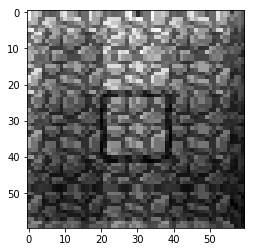

- Buffer Move 35 : move -1
- Move Array 35 : move -1
ZPos : 2.5
XPos : 5.5
Yaw : 180.0


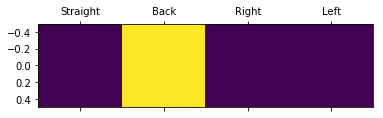

         0          1          0          0
Obtained reward : -0.01
-----------------------


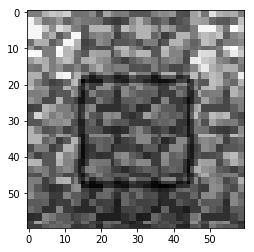

- Buffer Move 36 : turn 1
- Move Array 36 : turn 1
ZPos : 2.5
XPos : 5.5
Yaw : 270.0


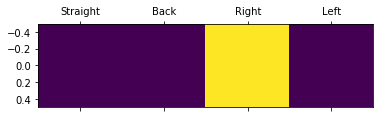

         0          0          1          0
Obtained reward : -0.01
-----------------------


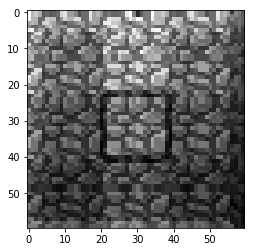

- Buffer Move 37 : turn -1
- Move Array 37 : turn -1
ZPos : 2.5
XPos : 5.5
Yaw : 180.0


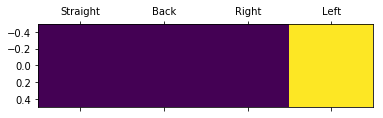

         0          0          0          1
Obtained reward : -0.01
-----------------------


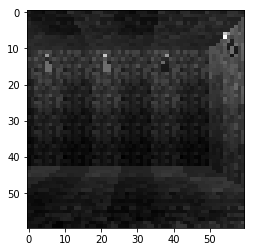

- Buffer Move 38 : turn -1
- Move Array 38 : turn -1
ZPos : 2.5
XPos : 5.5
Yaw : 90.0


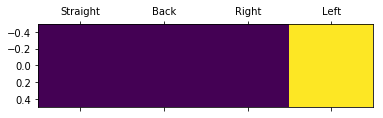

         0          0          0          1
Obtained reward : -0.01
-----------------------


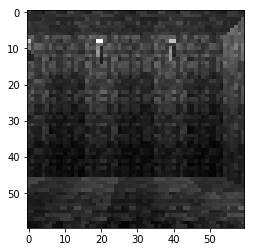

- Buffer Move 39 : move 1
- Move Array 39 : move 1


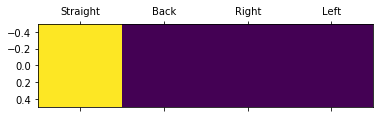

         1          0          0          0
Obtained reward : -1.0099999904632568
State error : State did not changed though the action was turn 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move -1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State e

KeyboardInterrupt: 

In [23]:
tf.reset_default_graph()
with tf.Session() as sess:
    
    #Use a Double Q-Network
    if NetType == ChooseNetwork.LSTM:
        cell = tf.contrib.rnn.BasicLSTMCell(num_units = num_nodes, state_is_tuple = True)
        cellT = tf.contrib.rnn.BasicLSTMCell(num_units = num_nodes, state_is_tuple = True)
        
        mainQN = NetType.value(cell, 'main')
        targetQN = NetType.value(cellT, 'target')
    elif NetType == ChooseNetwork.StackedConvolutional:
        mainQN = NetType.value(trace_length)
        targetQN = NetType.value(trace_length)
    else:
        mainQN = NetType.value()
        targetQN = NetType.value()
    
    trainables = tf.trainable_variables()
    targetOps = updateTargetGraph(trainables,tau)
    
    #Save the network
    saver = tf.train.Saver()
    path_to_save = "saves/" + str(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) + "/"
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    tb_infos_logger = TensorBoardInfosLogger()
    writer = tf.summary.FileWriter(write_path)
    
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path_to_save)
        saver.restore(sess,ckpt.model_checkpoint_path)
    
    for i in range(num_episodes):
        if NetType == ChooseNetwork.LSTM:
            lstm_state = (np.zeros([1, num_nodes]), np.zeros([1, num_nodes])) #Reset the recurrent layer's hidden state
            
        episodeBuffer = experience_buffer()

        s = env.reset()
        s = processState(s)
        d = False
        j = 0
        episode_frames = []
        episode_frames.append(s)
        episode_qvalues = []
        episode_rewards = []
        
        ZPos = []
        XPos = []
        Yaw = []
        moves = []
        
        while not d:
            j += 1
            
            ### Epsilon Greedy ###
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
            # Make full exploration before the number of pre-train episodes then play with an e chance of random action during the training (e-greedy)
            if(np.random.rand(1) < e or total_steps < pre_train_steps):
                if NetType == ChooseNetwork.LSTM:
                    lstm_state1 = sess.run(mainQN.rnn_state,\
                        feed_dict = {mainQN.x:[s], mainQN.train_length:1, \
                                     mainQN.lstm_state_in:lstm_state, mainQN.batch_size:1})
                index_action_predicted = env.action_space.sample()
                episode_qvalues.append([1 if i == index_action_predicted else 0 for i in range(len(env.action_names[0]))])
            else:
                if NetType == ChooseNetwork.LSTM:
                    if is_debug:
                        print_debug_states(sess, mainQN, s, trace_length)
                        
                    prediction, qvalues, lstm_state1 = sess.run([mainQN.prediction, mainQN.Qout, mainQN.rnn_state],\
                        feed_dict={mainQN.x:[s], mainQN.train_length:1, \
                                   mainQN.lstm_state_in:lstm_state, mainQN.batch_size:1})
                elif NetType == ChooseNetwork.StackedConvolutional:
                    stacked_s = get_stacked_states(episode_frames, trace_length)
                    
                    if is_debug:
                        print_debug_states(sess, mainQN, stacked_s, trace_length)
                            
                    prediction, qvalues = sess.run([mainQN.prediction, mainQN.Qout],\
                        feed_dict={mainQN.x:[stacked_s]})
                else:
                    if is_debug:
                        print_debug_states(sess, mainQN, s, trace_length)
                        
                    prediction, qvalues = sess.run([mainQN.prediction, mainQN.Qout], \
                                                      feed_dict = {mainQN.x:[s]})
                index_action_predicted = prediction[0]
                episode_qvalues.append(qvalues[0])
            
            #Get new state and reward from environment
            s1_raw, r, d, info = env.step(index_action_predicted)
                
            if info["observation"]:
                ZPos.append(info['observation']['ZPos'])
                XPos.append(info['observation']['XPos'])
                Yaw.append(info['observation']['Yaw'])
            s1 = processState(s1_raw)
            moves.append(index_action_predicted)
            episodeBuffer.add(np.reshape(np.array([s, index_action_predicted, r, s1, d]), [1, 5]))
            episode_frames.append(s1)
            
            if total_steps > pre_train_steps:
                if total_steps % (update_freq) == 0:
                    
                    updateTarget(targetOps,sess) #Update Target Network
                    
                    if NetType == ChooseNetwork.LSTM:
                        lstm_state_train = (np.zeros([batch_size, num_nodes]), \
                                            np.zeros([batch_size, num_nodes]))
                        
                        trainBatch = myBuffer.sample(batch_size, trace_length)
                        
                        if is_debug:
                            print_debug_states(sess, mainQN, trainBatch[0, 0], trace_length)
                        
                        #Estimate the action to choose by our first network
                        actionChosen = sess.run(mainQN.prediction, \
                                                feed_dict = {mainQN.x:np.vstack(trainBatch[:, 3]), \
                                                             mainQN.train_length:trace_length, \
                                                             mainQN.lstm_state_in:lstm_state_train, \
                                                             mainQN.batch_size:batch_size})
                        #Estimate all the Q-values by our second network --> Double
                        allQValues = sess.run(targetQN.Qout, \
                                              feed_dict = {targetQN.x:np.vstack(trainBatch[:, 3]), \
                                                           targetQN.train_length:trace_length, \
                                                           targetQN.lstm_state_in:lstm_state_train, \
                                                           targetQN.batch_size:batch_size})

                        #Train our network using target and predicted Q-values
                        end_multiplier = -(trainBatch[:, 4] -1)
                        maxQ = allQValues[range(batch_size*trace_length), actionChosen]
                        #Bellman Equation
                        targetQ = trainBatch[:, 2] + (y * maxQ * end_multiplier)

                        _, summaryPlot = sess.run([mainQN.updateModel, mainQN.merged], \
                                                  feed_dict = {mainQN.x:np.vstack(trainBatch[:, 0]), \
                                                               mainQN.nextQ:targetQ, \
                                                               mainQN.actions:trainBatch[:, 1], \
                                                               mainQN.train_length:trace_length, \
                                                               mainQN.lstm_state_in:lstm_state_train, \
                                                               mainQN.batch_size:batch_size})
                        
                    elif NetType == ChooseNetwork.StackedConvolutional:
                        trainBatch = myBuffer.sample(batch_size, trace_length)
                        
                        if is_debug:
                            print_debug_states(sess, mainQN, trainBatch[0, 0], trace_length)
                        
                        #Estimate the action to choose by our first network
                        actionChosen = sess.run(mainQN.prediction, \
                                                feed_dict = {mainQN.x:np.vstack(trainBatch[:, 3])})
                        #Estimate all the Q-values by our second network --> Double
                        allQValues = sess.run(targetQN.Qout, \
                                              feed_dict = {targetQN.x:np.vstack(trainBatch[:, 3])})

                        #Train our network using target and predicted Q-values
                        end_multiplier = -(trainBatch[:, 4] -1)
                        maxQ = allQValues[range(batch_size), actionChosen]
                        #Bellman Equation
                        targetQ = trainBatch[:, 2] + (y * maxQ * end_multiplier)

                        _, summaryPlot = sess.run([mainQN.updateModel, mainQN.merged], \
                                                  feed_dict = {mainQN.x:np.vstack(trainBatch[:, 0]), \
                                                               mainQN.nextQ:targetQ, \
                                                               mainQN.actions:trainBatch[:, 1]})
                    
                    else:
                        trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                        
                        if is_debug:
                            print_debug_states(sess, mainQN, trainBatch[0, 0], trace_length)
                    
                        #Estimate the action to choose by our first network
                        actionChosen = sess.run(mainQN.prediction, \
                                                feed_dict = {mainQN.x:np.vstack(trainBatch[:, 3])})
                        #Estimate all the Q-values by our second network --> Double
                        allQValues = sess.run(targetQN.Qout, \
                                              feed_dict = {targetQN.x:np.vstack(trainBatch[:, 3])})

                        #Train our network using target and predicted Q-values
                        end_multiplier = -(trainBatch[:, 4] -1)
                        maxQ = allQValues[range(batch_size), actionChosen]
                        #Bellman Equation
                        targetQ = trainBatch[:, 2] + (y * maxQ * end_multiplier)

                        _, summaryPlot = sess.run([mainQN.updateModel, mainQN.merged], \
                                                  feed_dict = {mainQN.x:np.vstack(trainBatch[:, 0]), \
                                                               mainQN.nextQ:targetQ, \
                                                               mainQN.actions:trainBatch[:, 1]})
                        
                    writer.add_summary(summaryPlot, total_steps)  
                    
            episode_rewards.append(r)
            if (s == s1).all():
                print("State error : State did not changed though the action was " + env.action_names[0][index_action_predicted])
            
            s = s1
            total_steps += 1
            if NetType == ChooseNetwork.LSTM:
                lstm_state = lstm_state1
                
            if d == True:
                if r == 0 or r == 10 or r == -10:
                    print("Unrecognized reward Error : " + str(r))
                    j_by_loss.append(j)
                elif r > 0:
                    j_by_win.append(j)
                elif r < 0:
                    j_by_nothing.append(j)                    
                break
                  
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(sum(episode_rewards))
        rewards = np.array(rList)
        
        if i % (50) == 0:
            nb_of_win_on_last_50 = (len(j_by_win) - nb_win_tb)
            win_perc = nb_of_win_on_last_50/50*100
            mean_j_by_win = np.mean(j_by_win[-nb_of_win_on_last_50:])
            mean_rewards_sum = np.mean(rList[-50:])
            summaryPlot = sess.run(tb_infos_logger.merged, 
                                   feed_dict = {tb_infos_logger.percent_win: win_perc, \
                                                tb_infos_logger.mean_j_by_win: mean_j_by_win, \
                                                tb_infos_logger.mean_rewards_sum: mean_rewards_sum})                       
            writer.add_summary(summaryPlot, i)  
            nb_win_tb = len(j_by_win)
        
        if i % (500) == 0:
            print("#######################################")
            print("% Win : " + str((len(j_by_win) - nb_win)/5) + "%")
            print("% Nothing : " + str((len(j_by_nothing) - nb_nothing)/5) + "%")
            print("% Loss : " + str((len(j_by_loss) - nb_loss)/5) + "%")
            
            print("Nb J before win: " + str(np.mean(j_by_win[-(len(j_by_win) - nb_win):])))
            print("Nb J before die: " + str(np.mean(j_by_loss[-(len(j_by_loss) - nb_loss):])))
                  
            print("Total Steps: " + str(total_steps))
            print("I: " + str(i))
            print("Epsilon: ", str(e))
                  
            nb_win = len(j_by_win)
            nb_nothing = len(j_by_nothing)
            nb_loss = len(j_by_loss)
            
            print("#### LAST 5 MOVES of LAST EPISODE  ####")
            last_episode_moves = episodeBuffer.get()
            starting_point = j-5 if j >= 5 else 0
            for z in range(starting_point, j):  
                print("-----------------------")
                plt.imshow(reverse_processState(episode_frames[z]), cmap=plt.get_cmap("gray"))
                plt.show()

                print("- Buffer Move " + str(z) + " : " + env.action_names[0][last_episode_moves[z, 1]])
                print("- Move Array " + str(z) + " : " + env.action_names[0][moves[z]])
                if z != j-1:
                    print("ZPos : "+ str(ZPos[z]))
                    print("XPos : "+ str(XPos[z]))
                    print("Yaw : "+ str(Yaw[z]))
                figure = plt.figure()
                axes = figure.add_subplot(2, 1, 1)
                axes.matshow([episode_qvalues[z]])
                axes.set_xticks(range(len(env.action_names[0])))
                actions_names = ["Straight", "Back", "Right", "Left"]
                axes.set_xticklabels(actions_names)
                plt.show()

                print("         " + "          ".join(str(qval) for qval in episode_qvalues[z]))
                print("Obtained reward : " + str(episode_rewards[z]))
                
        if i % (5000)== 0 and i != 0:
            #Save all the other important values
            saver.save(sess, path_to_save + str(i) + '.ckpt')
            with open(path_to_save + str(i) + ".pickle", 'wb') as file:
                dictionnary = {
                    "epsilon": e,
                    "Total_steps": total_steps,
                    "Buffer": myBuffer,
                    "rList": rList,
                    "Num Episodes": i,
                    "jList": jList}
                
                pickle.dump(dictionnary, file, protocol = pickle.HIGHEST_PROTOCOL)
                
    saver.save(sess, path_to_save + str(i) + '.ckpt')

## Testing

In [56]:
nb_episodes_by_test = 100
nb_tests = 3
path_to_saved_model = "saves/LSTM/15000.ckpt"
test_print_freq = 50

In [57]:
NetType = ChooseNetwork.LSTM
trace_length = 4

Loading Model...
INFO:tensorflow:Restoring parameters from saves/LSTM/15000.ckpt
#### EPISODE 0 (TEST 0) MOVES ####
-----------------------


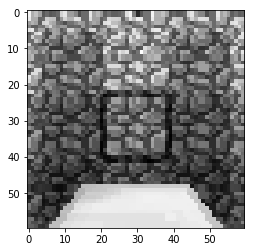

- Move Array 0 : move 1
ZPos : 1.5
XPos : 2.5
Yaw : 0.0


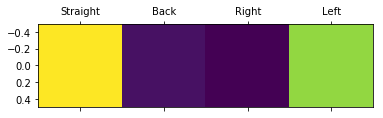

         -0.0048752762          -0.020699807          -0.021458482          -0.0075348485
Obtained reward : -0.01
-----------------------


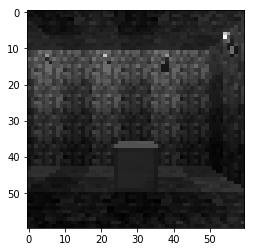

- Move Array 1 : move 1
ZPos : 2.5
XPos : 2.5
Yaw : 0.0


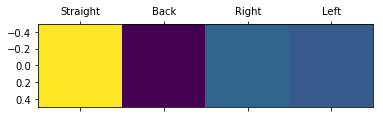

         0.17361453          0.136208          0.14837226          0.1469975
Obtained reward : -0.01
-----------------------


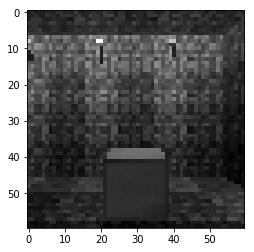

- Move Array 2 : move 1
ZPos : 3.5
XPos : 2.5
Yaw : 0.0


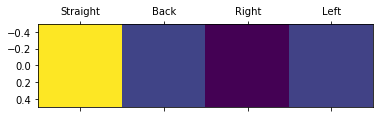

         0.5812345          0.51350856          0.49602133          0.5126799
Obtained reward : -0.01
-----------------------


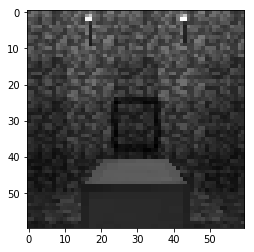

- Move Array 3 : move 1
ZPos : 4.5
XPos : 2.5
Yaw : 0.0


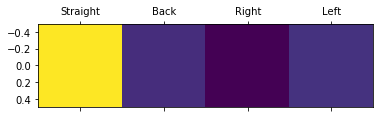

         0.92984325          0.83695024          0.82298034          0.83863384
Obtained reward : -0.01
-----------------------


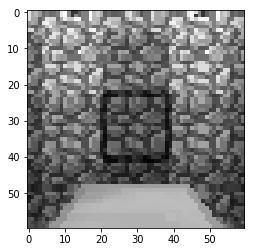

- Move Array 4 : move 1


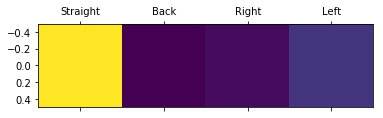

         1.121196          0.9962611          1.0000938          1.0154471
Obtained reward : 0.9900000095367432
State error : State did not changed though the action was move 1
Max steps reached
Max steps reached
Max steps reached
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
Max steps reached
#### EPISODE 50 (TEST 0) MOVES ####
-----------------------


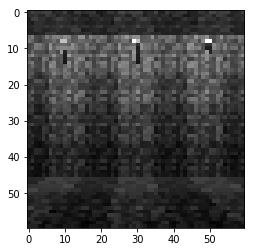

- Move Array 0 : move -1
ZPos : 0.5
XPos : 2.5
Yaw : 0.0


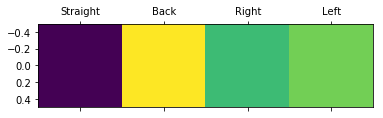

         -0.015060563          -0.0037234202          -0.007293904          -0.0061369594
Obtained reward : -0.01
-----------------------


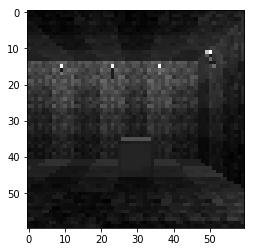

- Move Array 1 : move 1
ZPos : 1.5
XPos : 2.5
Yaw : 0.0


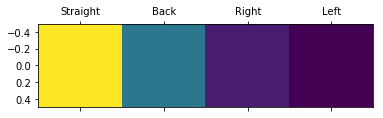

         0.17622453          0.16019526          0.15182744          0.14970034
Obtained reward : -0.01
-----------------------


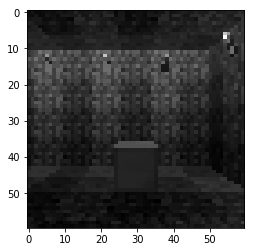

- Move Array 2 : move 1
ZPos : 2.5
XPos : 2.5
Yaw : 0.0


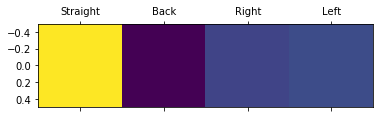

         0.56801134          0.4864059          0.5029998          0.5053405
Obtained reward : -0.01
-----------------------


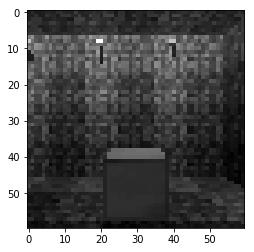

- Move Array 3 : move 1
ZPos : 3.5
XPos : 2.5
Yaw : 0.0


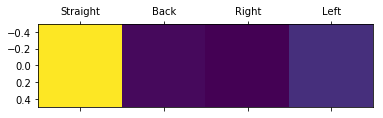

         0.8838819          0.7784146          0.7755548          0.79002124
Obtained reward : -0.01
-----------------------


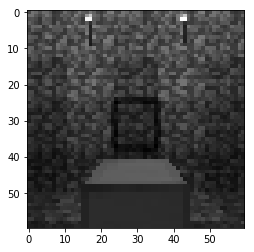

- Move Array 4 : move 1
ZPos : 4.5
XPos : 2.5
Yaw : 0.0


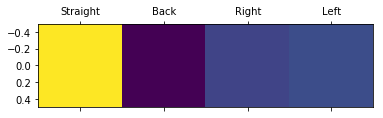

         1.0454884          0.9031947          0.93247586          0.9367656
Obtained reward : -0.01
-----------------------


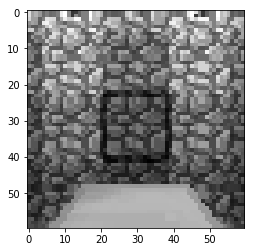

- Move Array 5 : move 1


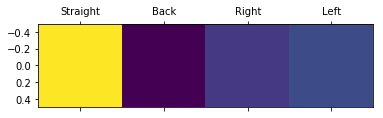

         1.1465069          0.9691676          0.9984922          1.009605
Obtained reward : 0.9900000095367432
Max steps reached
Max steps reached
State error : State did not changed though the action was move -1
State error : State did not changed though the action was move 1
Max steps reached
Max steps reached
Max steps reached
#### EPISODE 0 (TEST 1) MOVES ####
-----------------------


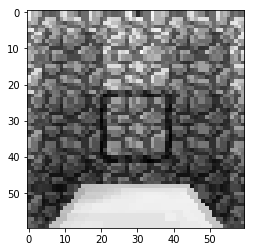

- Move Array 0 : move 1
ZPos : 1.5
XPos : 2.5
Yaw : 0.0


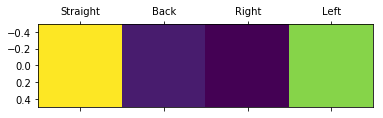

         -0.0049881972          -0.02067656          -0.021935089          -0.008064445
Obtained reward : -0.01
-----------------------


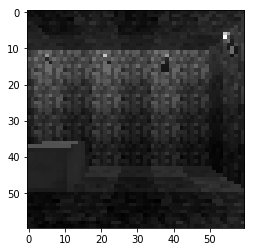

- Move Array 1 : move 1
ZPos : 2.5
XPos : 2.5
Yaw : 0.0


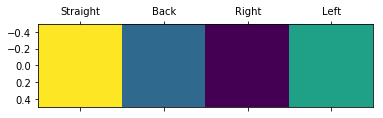

         0.1375314          0.12155777          0.11324316          0.12710097
Obtained reward : -0.01
-----------------------


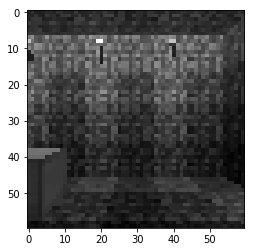

- Move Array 2 : turn -1
ZPos : 2.5
XPos : 2.5
Yaw : 270.0


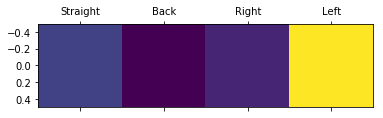

         0.42945966          0.42350274          0.42676696          0.45446837
Obtained reward : -0.01
-----------------------


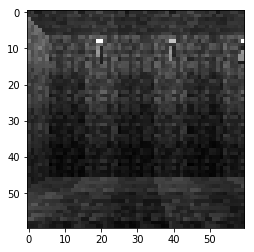

- Move Array 3 : turn -1
ZPos : 2.5
XPos : 2.5
Yaw : 180.0


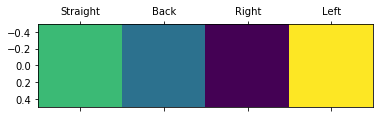

         0.73064417          0.68977827          0.6407144          0.7723988
Obtained reward : -0.01
-----------------------


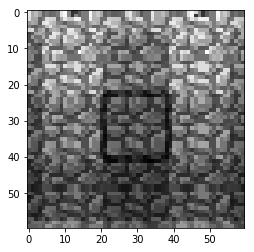

- Move Array 4 : move -1
ZPos : 3.5
XPos : 2.5
Yaw : 180.0


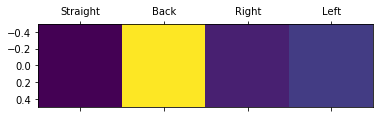

         0.8414725          0.92052877          0.84840876          0.8555122
Obtained reward : -0.01
-----------------------


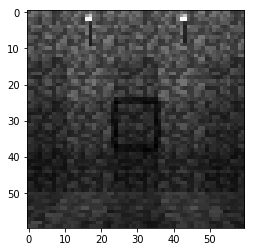

- Move Array 5 : move -1
ZPos : 4.5
XPos : 2.5
Yaw : 180.0


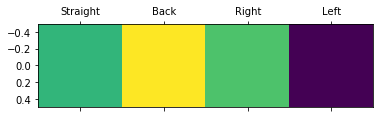

         0.8232383          0.87351125          0.8327056          0.7269993
Obtained reward : -0.01
-----------------------


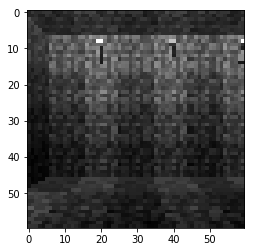

- Move Array 6 : move -1
ZPos : 5.5
XPos : 2.5
Yaw : 180.0


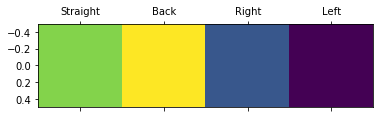

         0.76999485          0.7969271          0.6902639          0.6506409
Obtained reward : -0.01
-----------------------


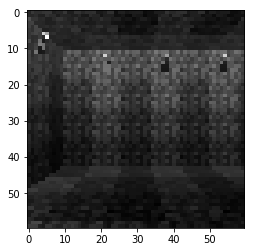

- Move Array 7 : move 1
ZPos : 4.5
XPos : 2.5
Yaw : 180.0


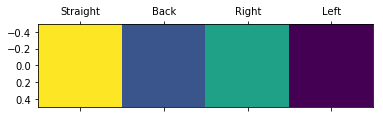

         0.7651015          0.6149964          0.6779234          0.5610142
Obtained reward : -0.01
-----------------------


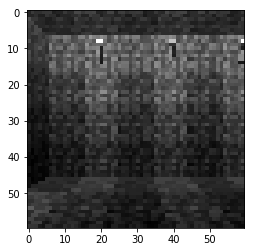

- Move Array 8 : move 1
ZPos : 3.5
XPos : 2.5
Yaw : 180.0


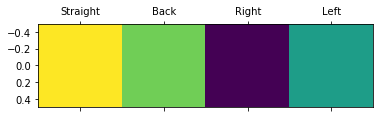

         0.7203061          0.6959126          0.60772985          0.67030674
Obtained reward : -0.01
-----------------------


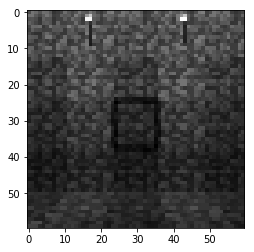

- Move Array 9 : move -1
ZPos : 4.5
XPos : 2.5
Yaw : 180.0


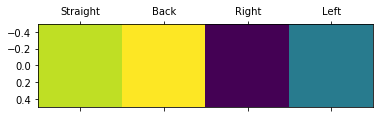

         0.75459164          0.76070225          0.69648325          0.7230748
Obtained reward : -0.01
-----------------------


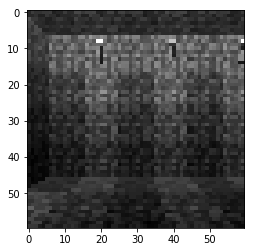

- Move Array 10 : move 1
ZPos : 3.5
XPos : 2.5
Yaw : 180.0


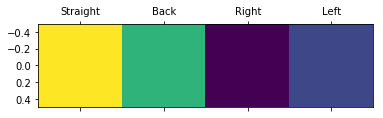

         0.87013745          0.83000964          0.7548664          0.7799605
Obtained reward : -0.01
-----------------------


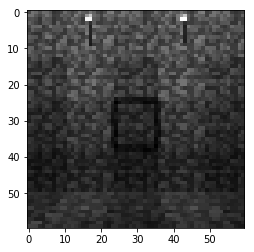

- Move Array 11 : move 1
ZPos : 2.5
XPos : 2.5
Yaw : 180.0


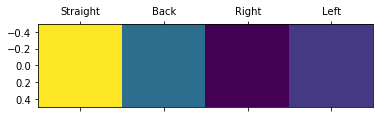

         0.8893788          0.830266          0.79696566          0.8123006
Obtained reward : -0.01
-----------------------


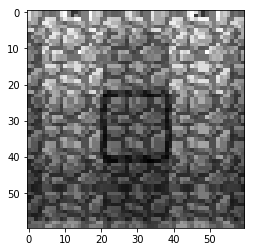

- Move Array 12 : move 1
ZPos : 1.5
XPos : 2.5
Yaw : 180.0


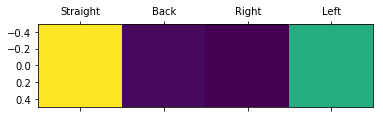

         0.87213326          0.747356          0.7441885          0.8232696
Obtained reward : -0.01
-----------------------


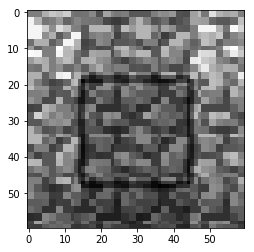

- Move Array 13 : turn -1
ZPos : 1.5
XPos : 2.5
Yaw : 90.0


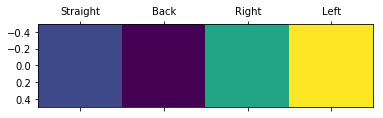

         0.67029196          0.6239449          0.7481741          0.8341504
Obtained reward : -0.01
-----------------------


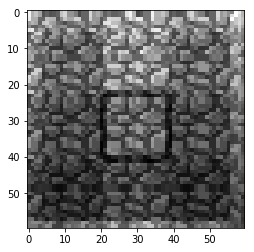

- Move Array 14 : move 1
ZPos : 1.5
XPos : 1.5
Yaw : 90.0


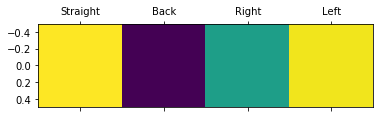

         0.70667803          0.62989956          0.6729214          0.7050143
Obtained reward : -0.01
-----------------------


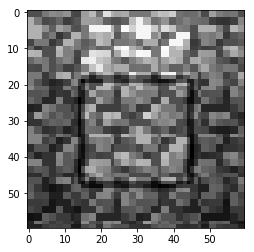

- Move Array 15 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 0.0


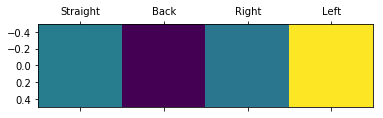

         0.6225857          0.54272985          0.6168799          0.73174095
Obtained reward : -0.01
-----------------------


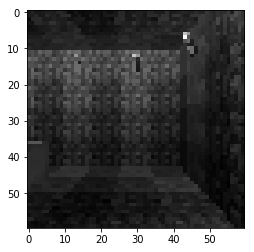

- Move Array 16 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 270.0


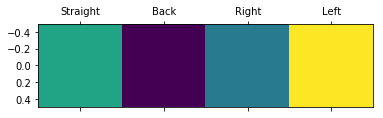

         0.6292542          0.4487195          0.57522714          0.7577869
Obtained reward : -0.01
-----------------------


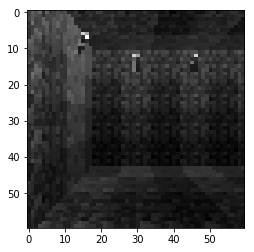

- Move Array 17 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 180.0


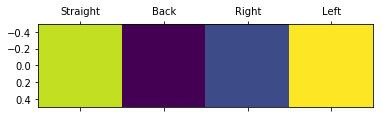

         0.69477886          0.45382297          0.51497537          0.7192771
Obtained reward : -0.01
-----------------------


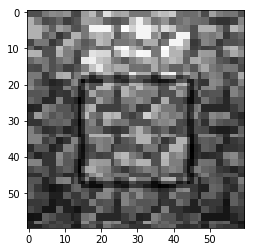

- Move Array 18 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 90.0


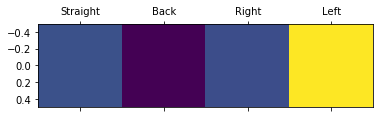

         0.6117135          0.56380486          0.60937446          0.7563107
Obtained reward : -0.01
-----------------------


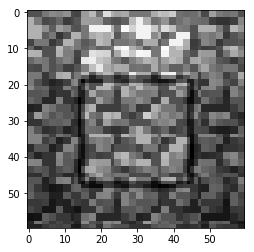

- Move Array 19 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 0.0


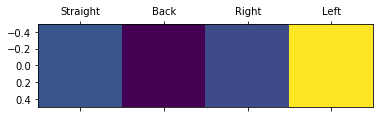

         0.6107116          0.5644218          0.6050484          0.7379067
Obtained reward : -0.01
-----------------------


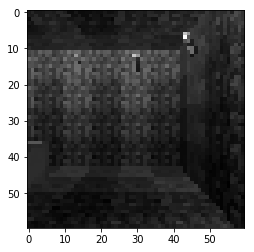

- Move Array 20 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 270.0


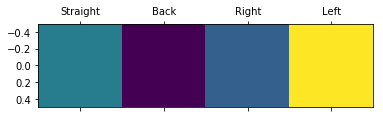

         0.5967042          0.47974646          0.56515145          0.7569632
Obtained reward : -0.01
-----------------------


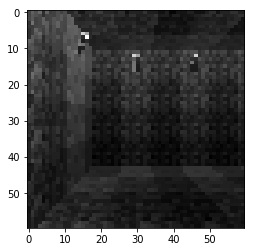

- Move Array 21 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 180.0


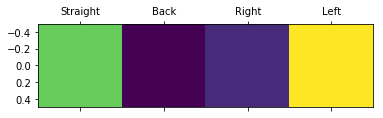

         0.6369876          0.4587311          0.48740909          0.6915267
Obtained reward : -0.01
-----------------------


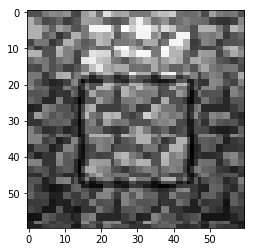

- Move Array 22 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 90.0


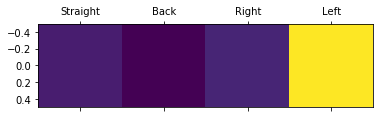

         0.5542367          0.54093945          0.55827904          0.70667267
Obtained reward : -0.01
-----------------------


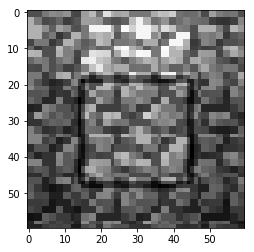

- Move Array 23 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 0.0


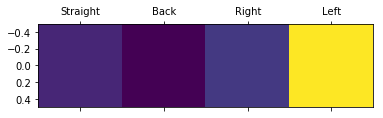

         0.56505114          0.54841614          0.5739519          0.70202494
Obtained reward : -0.01
-----------------------


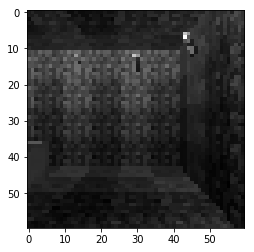

- Move Array 24 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 270.0


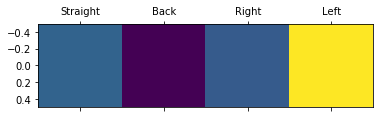

         0.5753959          0.49234378          0.5665609          0.7521526
Obtained reward : -0.01
-----------------------


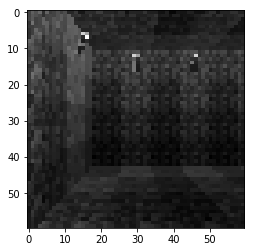

- Move Array 25 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 180.0


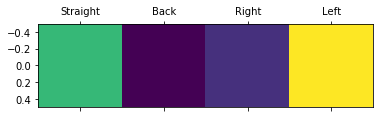

         0.6173325          0.4729225          0.5029006          0.68815804
Obtained reward : -0.01
-----------------------


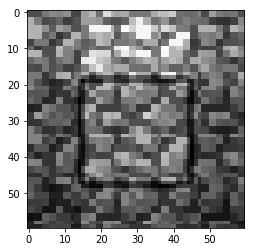

- Move Array 26 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 90.0


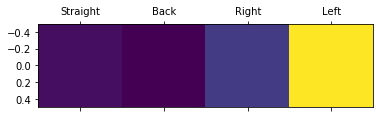

         0.55454475          0.5488378          0.5766532          0.70761406
Obtained reward : -0.01
-----------------------


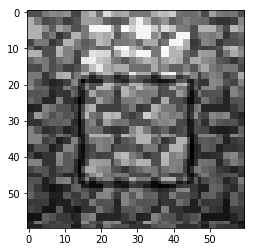

- Move Array 27 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 0.0


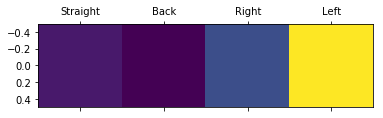

         0.5630735          0.5528239          0.5891559          0.70320565
Obtained reward : -0.01
-----------------------


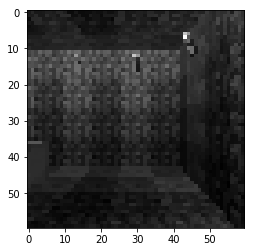

- Move Array 28 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 270.0


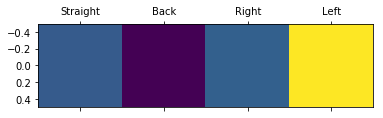

         0.5690731          0.4955197          0.57413834          0.75315523
Obtained reward : -0.01
-----------------------


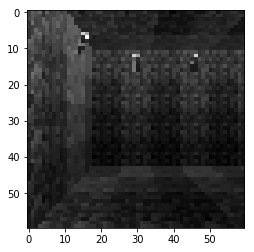

- Move Array 29 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 180.0


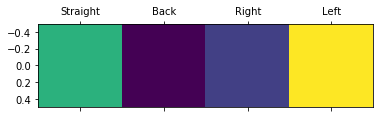

         0.60320324          0.4697662          0.50884104          0.678068
Obtained reward : -0.01
-----------------------


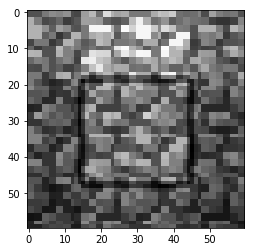

- Move Array 30 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 90.0


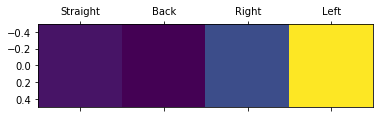

         0.547371          0.5389491          0.575545          0.6929567
Obtained reward : -0.01
-----------------------


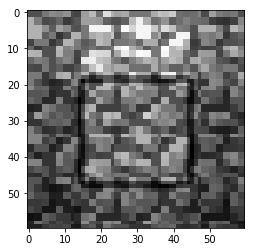

- Move Array 31 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 0.0


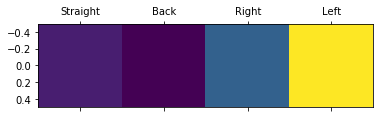

         0.555755          0.5435618          0.5884728          0.68845856
Obtained reward : -0.01
-----------------------


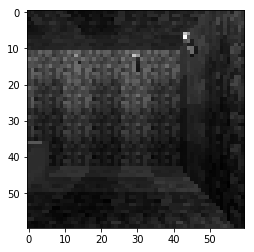

- Move Array 32 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 270.0


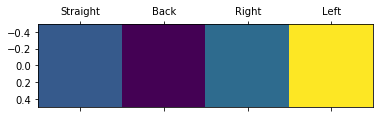

         0.56470895          0.49295175          0.5817229          0.7474533
Obtained reward : -0.01
-----------------------


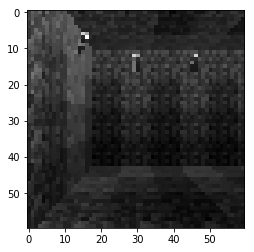

- Move Array 33 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 180.0


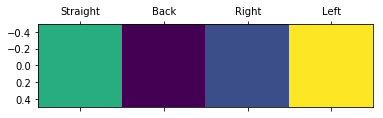

         0.59544          0.46616793          0.51626426          0.6741896
Obtained reward : -0.01
-----------------------


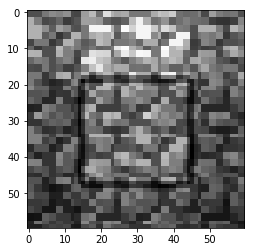

- Move Array 34 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 90.0


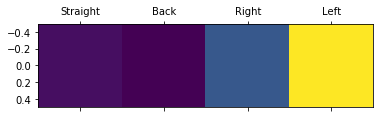

         0.53865236          0.533173          0.57530576          0.68528795
Obtained reward : -0.01
-----------------------


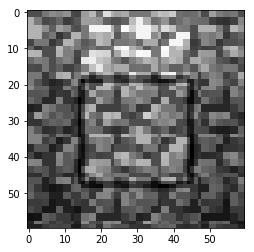

- Move Array 35 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 0.0


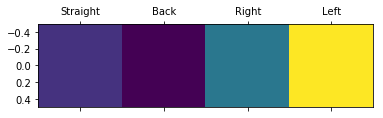

         0.55614537          0.535156          0.5923602          0.6792625
Obtained reward : -0.01
-----------------------


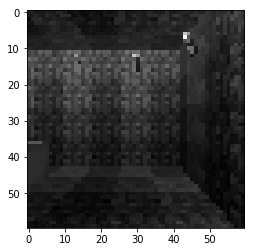

- Move Array 36 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 270.0


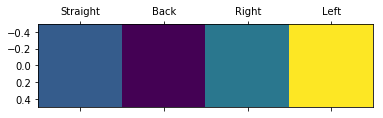

         0.56875044          0.49535716          0.5959705          0.7487944
Obtained reward : -0.01
-----------------------


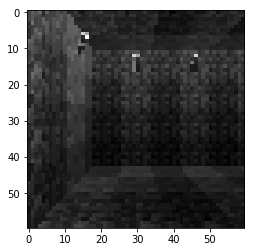

- Move Array 37 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 180.0


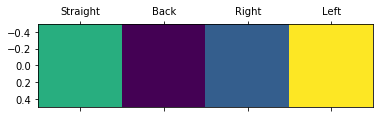

         0.600092          0.47263962          0.53330004          0.6760751
Obtained reward : -0.01
-----------------------


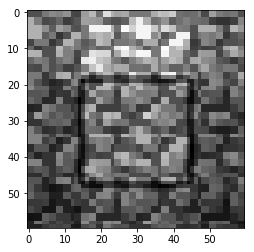

- Move Array 38 : turn -1
ZPos : 1.5
XPos : 1.5
Yaw : 90.0


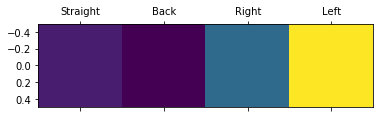

         0.5442949          0.532316          0.58558524          0.6870612
Obtained reward : -0.01
-----------------------


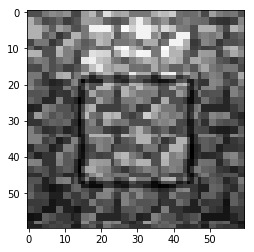

- Move Array 39 : turn -1


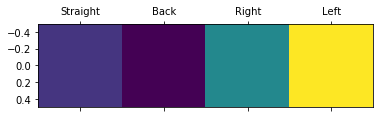

         0.5533017          0.5298365          0.6005514          0.68137527
Obtained reward : -1.0099999904632568
Max steps reached
State error : State did not changed though the action was move 1
Max steps reached
Max steps reached
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
Max steps reached
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
Max steps reached
Max steps reached
Max steps reached
State error : State did not changed though the action was move 1
Max steps reached
State error : State did not changed though the action was move 1
#### EPISODE 50 (TEST 1) M

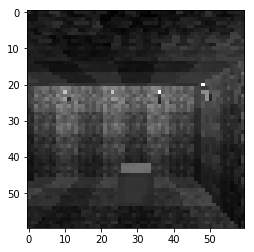

- Move Array 0 : move 1
ZPos : 1.5
XPos : 2.5
Yaw : 0.0


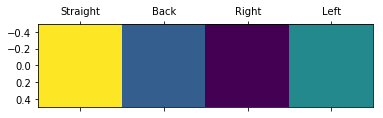

         -0.0064058825          -0.016639844          -0.021032693          -0.014159033
Obtained reward : -0.01
-----------------------


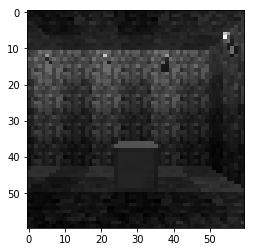

- Move Array 1 : move 1
ZPos : 2.5
XPos : 2.5
Yaw : 0.0


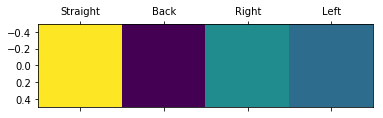

         0.17744733          0.14666988          0.16159007          0.1575389
Obtained reward : -0.01
-----------------------


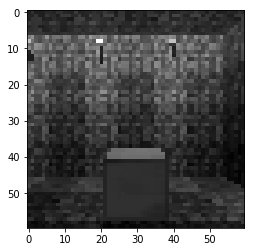

- Move Array 2 : move 1
ZPos : 3.5
XPos : 2.5
Yaw : 0.0


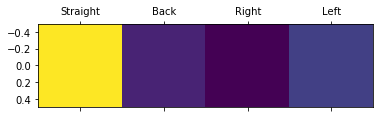

         0.58364743          0.5115441          0.50363594          0.5187611
Obtained reward : -0.01
-----------------------


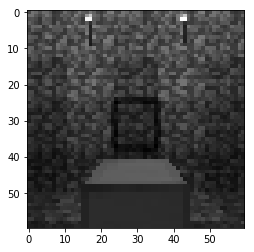

- Move Array 3 : move 1
ZPos : 4.5
XPos : 2.5
Yaw : 0.0


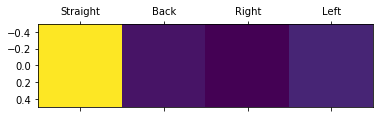

         0.9323906          0.834167          0.82854277          0.8393517
Obtained reward : -0.01
-----------------------


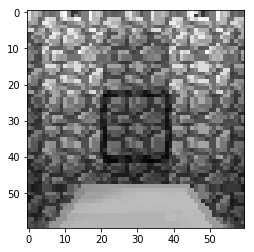

- Move Array 4 : move 1


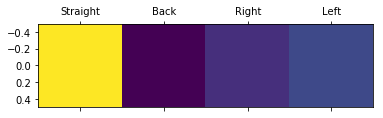

         1.1281135          0.9955444          1.0132586          1.0248151
Obtained reward : 0.9900000095367432
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
Max steps reached
State error : State did not changed though the action was move -1
State error : State did not changed though the action was move -1
State error : State did not changed though the action was move 1
Max steps reached
Max steps reached
Max steps reached
State error : State did not changed though the action was move 1
Max steps reached
#### EPISODE 0 (TEST 2) MOVES ####
-----------------------


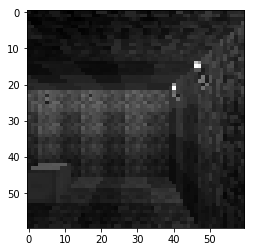

- Move Array 0 : move 1
ZPos : 1.5
XPos : 1.5
Yaw : 0.0


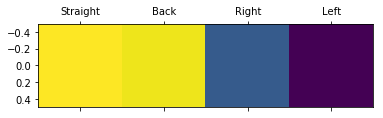

         -0.01023468          -0.010384083          -0.014136972          -0.015700953
Obtained reward : -0.01
-----------------------


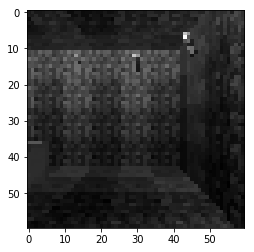

- Move Array 1 : move 1
ZPos : 2.5
XPos : 1.5
Yaw : 0.0


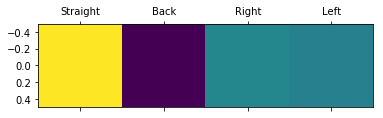

         0.12438382          0.11598678          0.11986804          0.11963372
Obtained reward : -0.01
-----------------------


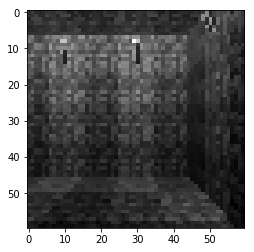

- Move Array 2 : turn 1
ZPos : 2.5
XPos : 1.5
Yaw : 90.0


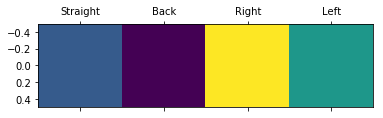

         0.37339154          0.36374015          0.3975409          0.38160807
Obtained reward : -0.01
-----------------------


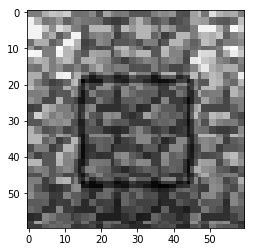

- Move Array 3 : turn 1
ZPos : 2.5
XPos : 1.5
Yaw : 180.0


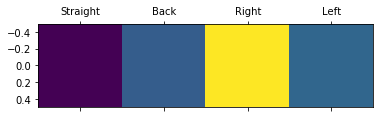

         0.5649372          0.5973622          0.67457235          0.6011988
Obtained reward : -0.01
-----------------------


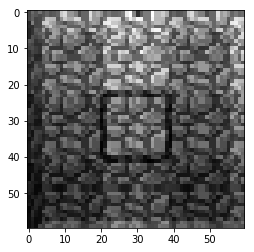

- Move Array 4 : turn 1
ZPos : 2.5
XPos : 1.5
Yaw : 270.0


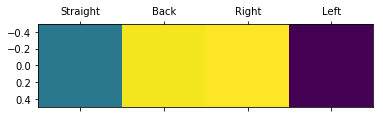

         0.7007811          0.73582274          0.7368033          0.67675656
Obtained reward : -0.01
-----------------------


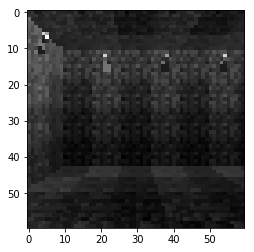

- Move Array 5 : move 1
ZPos : 2.5
XPos : 2.5
Yaw : 270.0


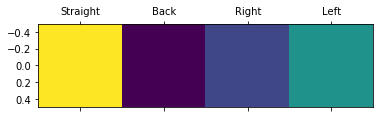

         0.7948217          0.5151268          0.57444775          0.6577866
Obtained reward : -0.01
-----------------------


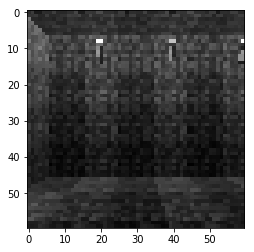

- Move Array 6 : move 1
ZPos : 2.5
XPos : 3.5
Yaw : 270.0


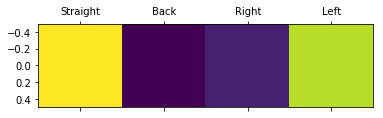

         0.7452236          0.52771807          0.5470571          0.7218135
Obtained reward : -0.01
-----------------------


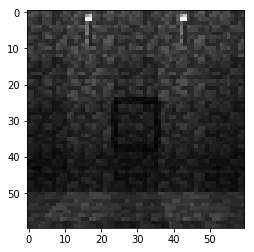

- Move Array 7 : move 1
ZPos : 2.5
XPos : 4.5
Yaw : 270.0


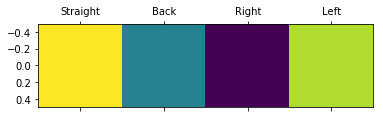

         0.71468675          0.5916548          0.49317244          0.6883854
Obtained reward : -0.01
-----------------------


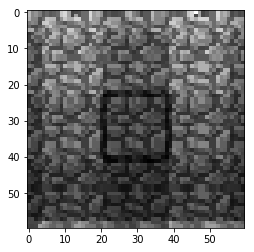

- Move Array 8 : move -1
ZPos : 2.5
XPos : 3.5
Yaw : 270.0


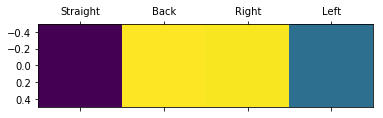

         0.6009901          0.6268113          0.62655234          0.6104225
Obtained reward : -0.01
-----------------------


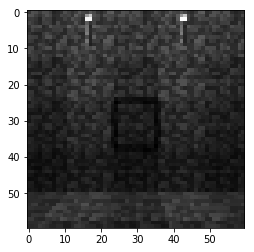

- Move Array 9 : turn -1
ZPos : 2.5
XPos : 3.5
Yaw : 180.0


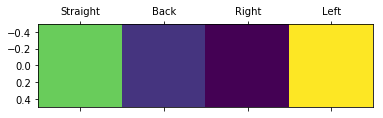

         0.6442043          0.5927776          0.58046985          0.663287
Obtained reward : -0.01
-----------------------


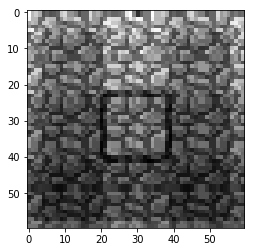

- Move Array 10 : move -1
ZPos : 3.5
XPos : 3.5
Yaw : 180.0


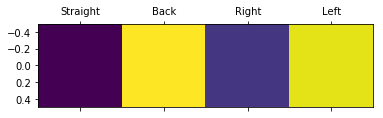

         0.6155041          0.681524          0.62582463          0.678826
Obtained reward : -0.01
-----------------------


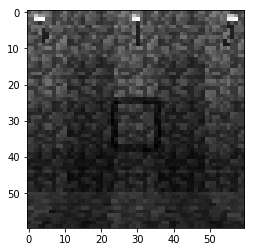

- Move Array 11 : move -1
ZPos : 4.5
XPos : 3.5
Yaw : 180.0


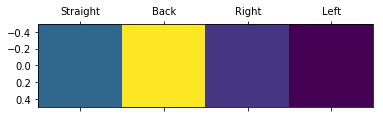

         0.71281886          0.7680779          0.69803536          0.68494844
Obtained reward : -0.01
-----------------------


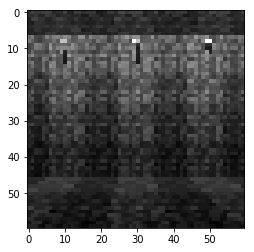

- Move Array 12 : move -1
ZPos : 5.5
XPos : 3.5
Yaw : 180.0


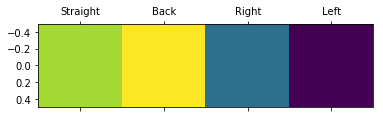

         0.8042075          0.8196425          0.74745286          0.7057151
Obtained reward : -0.01
-----------------------


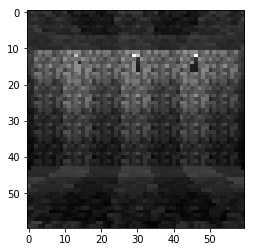

- Move Array 13 : move 1
ZPos : 4.5
XPos : 3.5
Yaw : 180.0


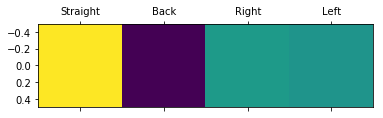

         0.8380068          0.72449297          0.78618336          0.78304935
Obtained reward : -0.01
-----------------------


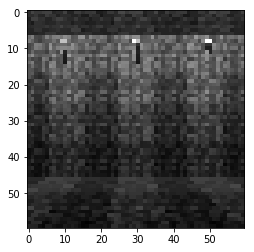

- Move Array 14 : move 1
ZPos : 3.5
XPos : 3.5
Yaw : 180.0


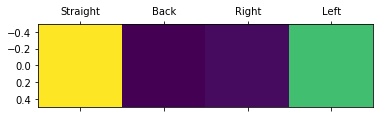

         0.84635633          0.7877107          0.7893769          0.8286643
Obtained reward : -0.01
-----------------------


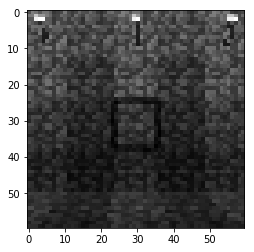

- Move Array 15 : move 1
ZPos : 2.5
XPos : 3.5
Yaw : 180.0


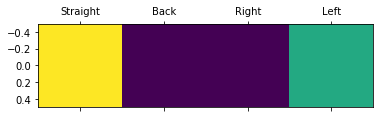

         0.84024113          0.79415417          0.79430914          0.82211787
Obtained reward : -0.01
-----------------------


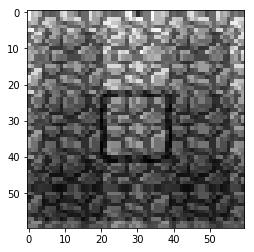

- Move Array 16 : turn -1
ZPos : 2.5
XPos : 3.5
Yaw : 90.0


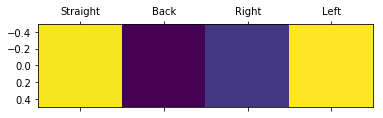

         0.78844863          0.68942446          0.705912          0.7899975
Obtained reward : -0.01
-----------------------


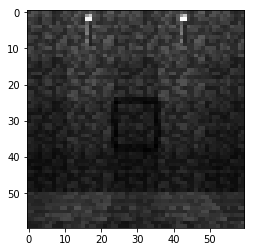

- Move Array 17 : move 1
ZPos : 2.5
XPos : 2.5
Yaw : 90.0


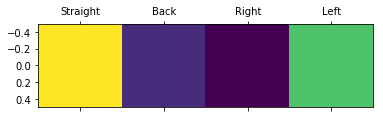

         0.80628794          0.7116283          0.69781166          0.7765689
Obtained reward : -0.01
-----------------------


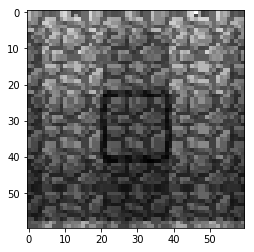

- Move Array 18 : move 1
ZPos : 2.5
XPos : 1.5
Yaw : 90.0


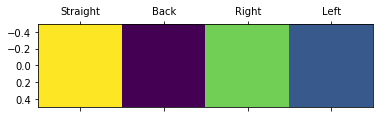

         0.741129          0.6904902          0.73035234          0.70468056
Obtained reward : -0.01
-----------------------


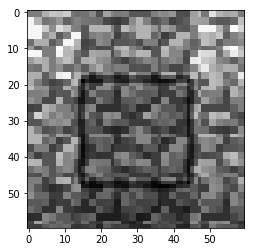

- Move Array 19 : turn -1
ZPos : 2.5
XPos : 1.5
Yaw : 0.0


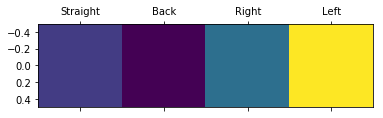

         0.63602084          0.6057773          0.6685065          0.7768396
Obtained reward : -0.01
-----------------------


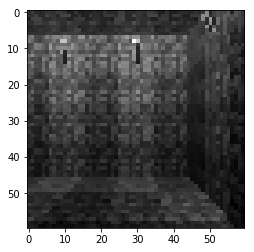

- Move Array 20 : turn -1
ZPos : 2.5
XPos : 1.5
Yaw : 270.0


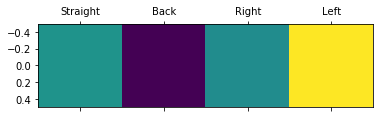

         0.65757364          0.5300633          0.65100133          0.77805555
Obtained reward : -0.01
-----------------------


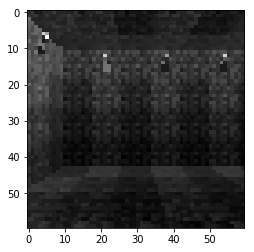

- Move Array 21 : turn -1
ZPos : 2.5
XPos : 1.5
Yaw : 180.0


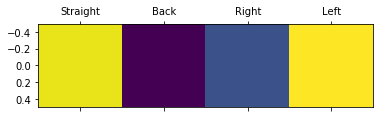

         0.73746055          0.4857679          0.5503859          0.74612224
Obtained reward : -0.01
-----------------------


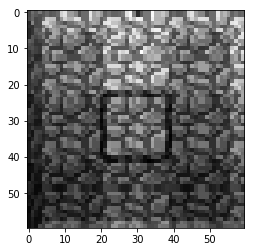

- Move Array 22 : turn -1
ZPos : 2.5
XPos : 1.5
Yaw : 90.0


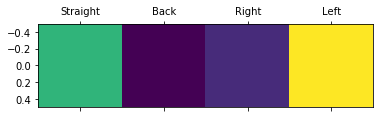

         0.6993543          0.61543834          0.6312532          0.7438049
Obtained reward : -0.01
-----------------------


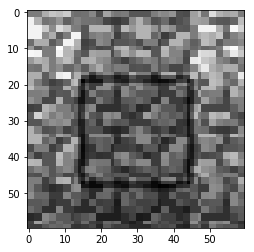

- Move Array 23 : turn -1
ZPos : 2.5
XPos : 1.5
Yaw : 0.0


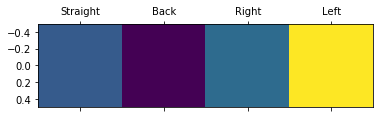

         0.61715853          0.5642345          0.6286442          0.74764276
Obtained reward : -0.01
-----------------------


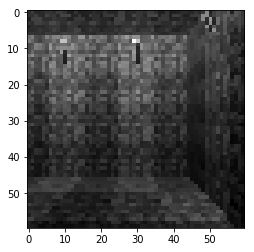

- Move Array 24 : turn -1
ZPos : 2.5
XPos : 1.5
Yaw : 270.0


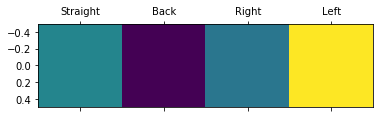

         0.6093929          0.487118          0.5924345          0.75638354
Obtained reward : -0.01
-----------------------


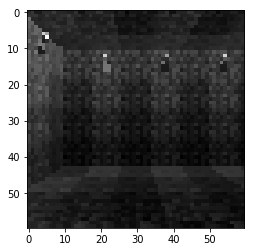

- Move Array 25 : turn -1
ZPos : 2.5
XPos : 1.5
Yaw : 180.0


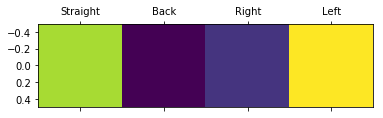

         0.694058          0.46785718          0.50680125          0.7282144
Obtained reward : -0.01
-----------------------


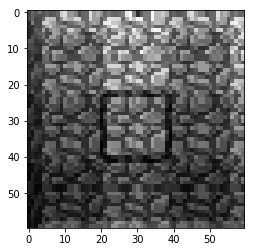

- Move Array 26 : turn -1
ZPos : 2.5
XPos : 1.5
Yaw : 90.0


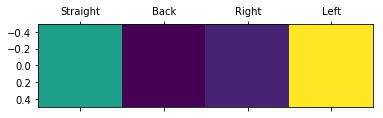

         0.6684116          0.59303415          0.606502          0.7264242
Obtained reward : -0.01
-----------------------


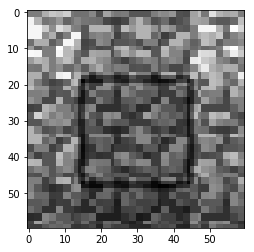

- Move Array 27 : turn -1
ZPos : 2.5
XPos : 1.5
Yaw : 0.0


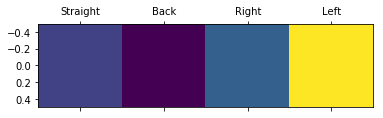

         0.603234          0.5659321          0.6253745          0.75925577
Obtained reward : -0.01
-----------------------


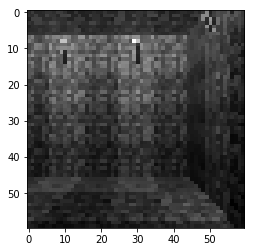

- Move Array 28 : turn -1
ZPos : 2.5
XPos : 1.5
Yaw : 270.0


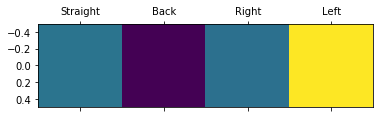

         0.61000085          0.50291604          0.6059289          0.7813138
Obtained reward : -0.01
-----------------------


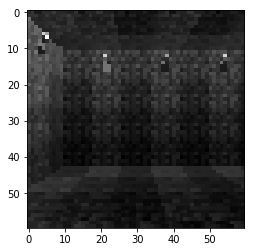

- Move Array 29 : turn -1
ZPos : 2.5
XPos : 1.5
Yaw : 180.0


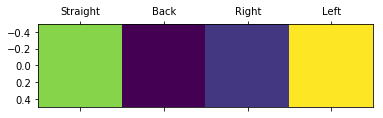

         0.70082194          0.48498613          0.5281513          0.748972
Obtained reward : -0.01
-----------------------


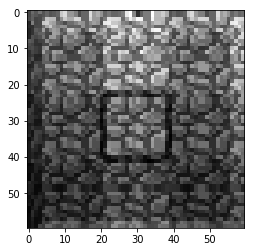

- Move Array 30 : turn -1
ZPos : 2.5
XPos : 1.5
Yaw : 90.0


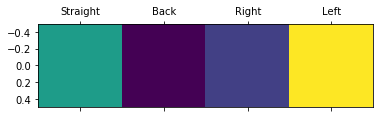

         0.67867446          0.6000193          0.62712157          0.7427429
Obtained reward : -0.01
-----------------------


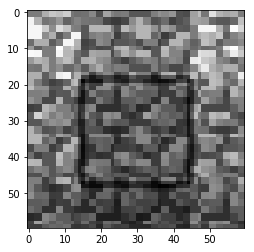

- Move Array 31 : turn -1
ZPos : 2.5
XPos : 1.5
Yaw : 0.0


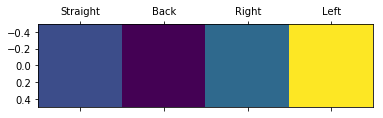

         0.6103173          0.56209296          0.63156915          0.76617855
Obtained reward : -0.01
-----------------------


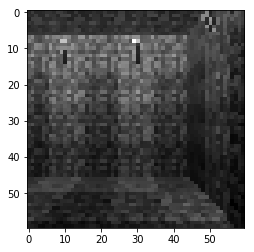

- Move Array 32 : turn -1
ZPos : 2.5
XPos : 1.5
Yaw : 270.0


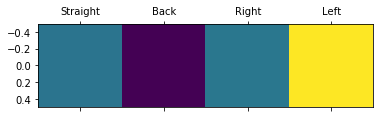

         0.60451627          0.49278313          0.60879356          0.7840339
Obtained reward : -0.01
-----------------------


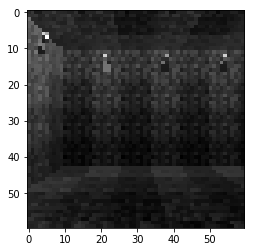

- Move Array 33 : turn -1
ZPos : 2.5
XPos : 1.5
Yaw : 180.0


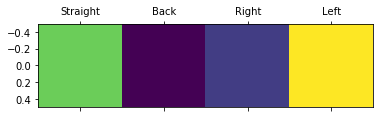

         0.6836012          0.47984445          0.5274592          0.7420395
Obtained reward : -0.01
-----------------------


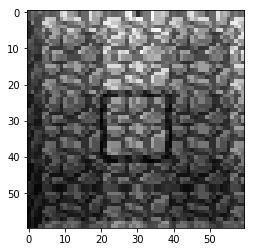

- Move Array 34 : turn -1
ZPos : 2.5
XPos : 1.5
Yaw : 90.0


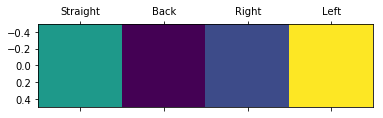

         0.6707667          0.5879343          0.62299365          0.7420535
Obtained reward : -0.01
-----------------------


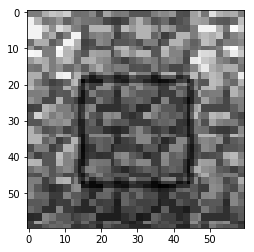

- Move Array 35 : turn -1
ZPos : 2.5
XPos : 1.5
Yaw : 0.0


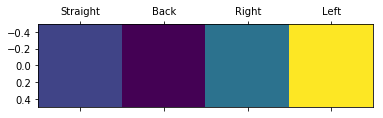

         0.60362107          0.55844957          0.6406177          0.77665967
Obtained reward : -0.01
-----------------------


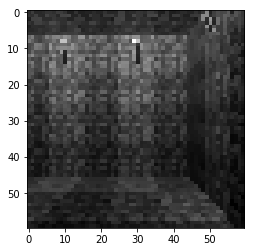

- Move Array 36 : turn -1
ZPos : 2.5
XPos : 1.5
Yaw : 270.0


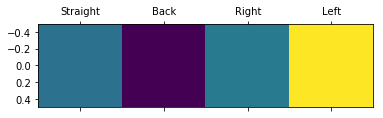

         0.61042756          0.5013819          0.6205934          0.7925036
Obtained reward : -0.01
-----------------------


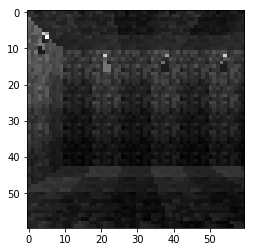

- Move Array 37 : turn -1
ZPos : 2.5
XPos : 1.5
Yaw : 180.0


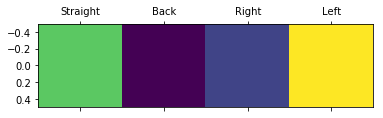

         0.68249077          0.4855008          0.5391947          0.7492563
Obtained reward : -0.01
-----------------------


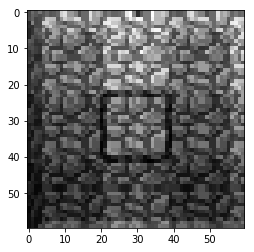

- Move Array 38 : turn -1
ZPos : 2.5
XPos : 1.5
Yaw : 90.0


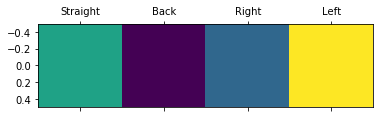

         0.6749171          0.5821085          0.63571244          0.7434098
Obtained reward : -0.01
-----------------------


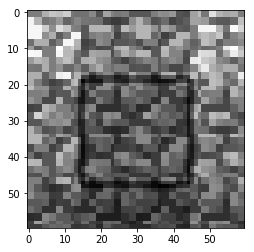

- Move Array 39 : turn -1


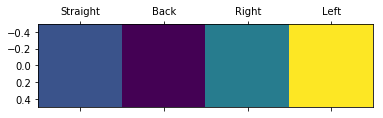

         0.607374          0.5502362          0.6441366          0.7745599
Obtained reward : -1.0099999904632568
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
Max steps reached
State error : State did not changed though the action was move -1
Max steps reached
State error : State did not changed though the action was move 1
Max steps reached
Max steps reached
Max steps reached
State error : State did not changed though the action was move 1
#### EPISODE 50 (TEST 2) MOVES ####
-----------------------


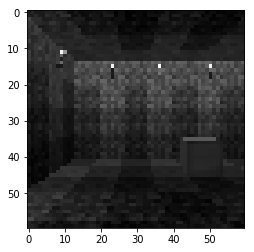

- Move Array 0 : turn -1
ZPos : 0.5
XPos : 4.5
Yaw : 270.0


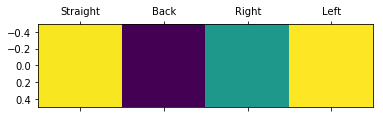

         -0.014931422          -0.023823895          -0.019032652          -0.014841644
Obtained reward : -0.01
-----------------------


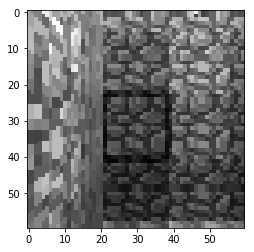

- Move Array 1 : move -1
ZPos : 0.5
XPos : 3.5
Yaw : 270.0


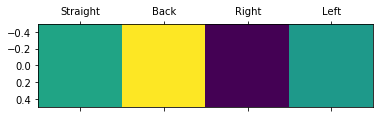

         0.1227255          0.128411          0.11480569          0.12209454
Obtained reward : -0.01
-----------------------


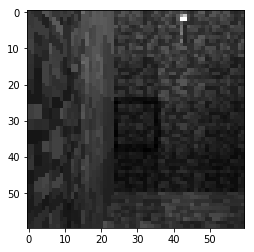

- Move Array 2 : move -1
ZPos : 0.5
XPos : 2.5
Yaw : 270.0


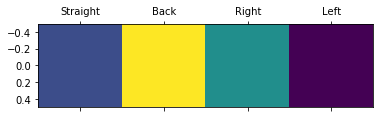

         0.39373657          0.41484523          0.40081367          0.38721097
Obtained reward : -0.01
-----------------------


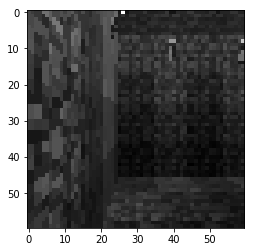

- Move Array 3 : move 1
ZPos : 0.5
XPos : 3.5
Yaw : 270.0


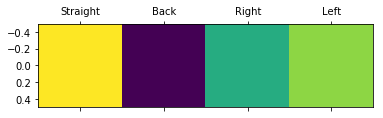

         0.57212204          0.53169394          0.5566786          0.5652963
Obtained reward : -0.01
-----------------------


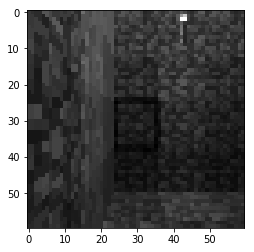

- Move Array 4 : move 1
ZPos : 0.5
XPos : 4.5
Yaw : 270.0


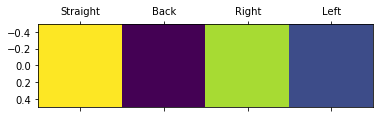

         0.6635735          0.60023266          0.6552442          0.6149417
Obtained reward : -0.01
-----------------------


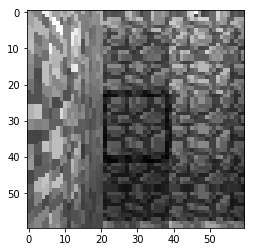

- Move Array 5 : turn 1
ZPos : 0.5
XPos : 4.5
Yaw : 0.0


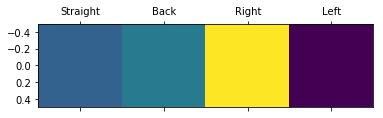

         0.5683549          0.58333427          0.67769915          0.51781535
Obtained reward : -0.01
-----------------------


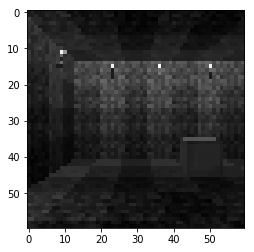

- Move Array 6 : move 1
ZPos : 1.5
XPos : 4.5
Yaw : 0.0


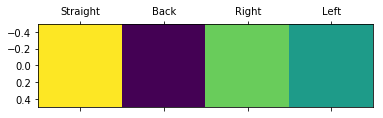

         0.49624306          0.32485294          0.4570474          0.4186765
Obtained reward : -0.01
-----------------------


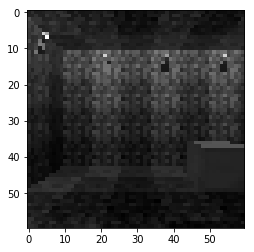

- Move Array 7 : move 1
ZPos : 2.5
XPos : 4.5
Yaw : 0.0


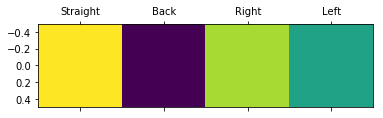

         0.5073192          0.3493644          0.48642007          0.44018587
Obtained reward : -0.01
-----------------------


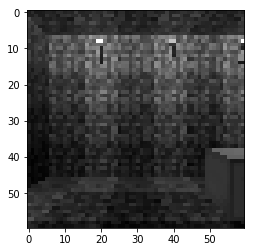

- Move Array 8 : move 1
ZPos : 3.5
XPos : 4.5
Yaw : 0.0


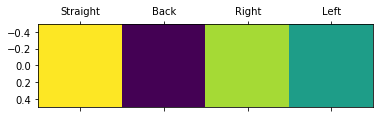

         0.5568896          0.38552457          0.5336775          0.48083997
Obtained reward : -0.01
-----------------------


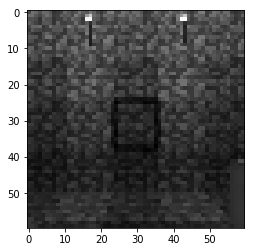

- Move Array 9 : move 1
ZPos : 4.5
XPos : 4.5
Yaw : 0.0


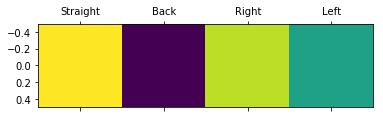

         0.63800585          0.45275056          0.6195139          0.5590163
Obtained reward : -0.01
-----------------------


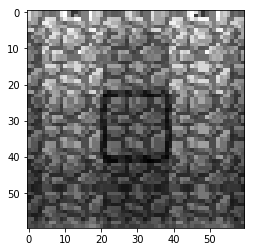

- Move Array 10 : move 1
ZPos : 5.5
XPos : 4.5
Yaw : 0.0


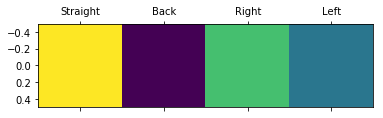

         0.7552674          0.55223113          0.695083          0.6318452
Obtained reward : -0.01
-----------------------


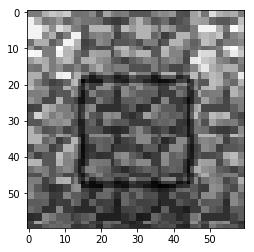

- Move Array 11 : turn 1
ZPos : 5.5
XPos : 4.5
Yaw : 90.0


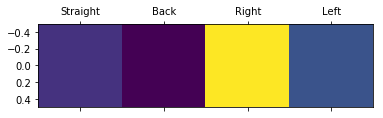

         0.6041821          0.565276          0.828968          0.63236845
Obtained reward : -0.01
-----------------------


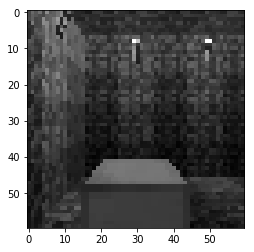

- Move Array 12 : move 1
ZPos : 5.5
XPos : 3.5
Yaw : 90.0


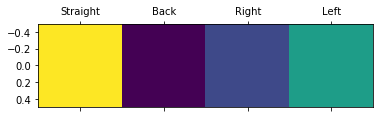

         0.9090142          0.6604532          0.71487254          0.7989253
Obtained reward : -0.01
-----------------------


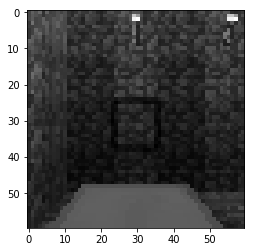

- Move Array 13 : move 1


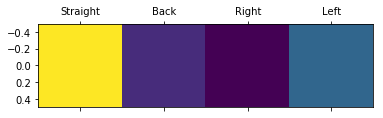

         0.99882317          0.791755          0.7612052          0.8399509
Obtained reward : 0.9900000095367432
State error : State did not changed though the action was move -1
Max steps reached
Max steps reached
Max steps reached
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move 1
State error : State did not changed though the action was move -1


In [58]:
tf.reset_default_graph()
with tf.Session() as sess:
    
    if NetType == ChooseNetwork.LSTM:
        cell = tf.contrib.rnn.BasicLSTMCell(num_units = num_nodes, state_is_tuple = True)
        mainQN = NetType.value(cell, 'main')
    elif NetType == ChooseNetwork.StackedConvolutional:
        mainQN = NetType.value(trace_length)
    else:
        mainQN = NetType.value()
    
    saver = tf.train.Saver()
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    print('Loading Model...')
    saver.restore(sess, path_to_saved_model)
      
    tests_results = []
    for test in range(nb_tests):
        episode_nb_win = 0
        episode_j_by_win = []
        for episode in range(nb_episodes_by_test):
            if NetType == ChooseNetwork.LSTM:
                lstm_state = (np.zeros([1, num_nodes]), np.zeros([1, num_nodes])) #Reset the recurrent layer's hidden state

            s = env.reset()
            s = processState(s)
            d = False
            j = 0
            episode_frames = []
            episode_frames.append(s)
            episode_qvalues = []
            episode_rewards = []

            ZPos = []
            XPos = []
            Yaw = []
            moves = []

            while not d:
                j += 1

                if NetType == ChooseNetwork.LSTM:
                    prediction, qvalues, lstm_state1 = sess.run([mainQN.prediction, mainQN.Qout, mainQN.rnn_state],\
                        feed_dict={mainQN.x:[s], mainQN.train_length:1, \
                                   mainQN.lstm_state_in:lstm_state, mainQN.batch_size:1})
                elif NetType == ChooseNetwork.StackedConvolutional:
                    stacked_s = get_stacked_states(episode_frames, trace_length)
                    prediction, qvalues = sess.run([mainQN.prediction, mainQN.Qout],\
                        feed_dict={mainQN.x:[stacked_s]})
                else:
                    prediction, qvalues = sess.run([mainQN.prediction, mainQN.Qout], \
                                                      feed_dict = {mainQN.x:[s]})
                index_action_predicted = prediction[0]
                episode_qvalues.append(qvalues[0])

                #Get new state and reward from environment
                s1_raw, r, d, info = env.step(index_action_predicted)

                if info["observation"]:
                    ZPos.append(info['observation']['ZPos'])
                    XPos.append(info['observation']['XPos'])
                    Yaw.append(info['observation']['Yaw'])
                s1 = processState(s1_raw)
                moves.append(index_action_predicted)
                episode_frames.append(s1)
                episode_rewards.append(r)
                if (s == s1).all():
                    print("State error : State did not changed though the action was " + env.action_names[0][index_action_predicted])

                s = s1
                if NetType == ChooseNetwork.LSTM:
                    lstm_state = lstm_state1

                if d == True:
                    if r == 0 or r == 10 or r == -10:
                        print("Unrecognized reward Error : " + str(r))
                    elif r > 0:
                        episode_nb_win+= 1
                        episode_j_by_win.append(j)
                    elif r < 0:
                        print("Max steps reached")                    
                    break
            
            if episode % (test_print_freq) == 0:
                print("#### EPISODE " + str(episode) + " (TEST " + str(test) + ") MOVES ####")
                for z in range(j):  
                    print("-----------------------")
                    plt.imshow(reverse_processState(episode_frames[z]), cmap=plt.get_cmap("gray"))
                    plt.show()

                    print("- Move Array " + str(z) + " : " + env.action_names[0][moves[z]])
                    if z != j-1:
                        print("ZPos : "+ str(ZPos[z]))
                        print("XPos : "+ str(XPos[z]))
                        print("Yaw : "+ str(Yaw[z]))
                    figure = plt.figure()
                    axes = figure.add_subplot(2, 1, 1)
                    axes.matshow([episode_qvalues[z]])
                    axes.set_xticks(range(len(env.action_names[0])))
                    actions_names = ["Straight", "Back", "Right", "Left"]
                    axes.set_xticklabels(actions_names)
                    plt.show()

                    print("         " + "          ".join(str(qval) for qval in episode_qvalues[z]))
                    print("Obtained reward : " + str(episode_rewards[z]))

        tests_results.append({
            "nb_win": episode_nb_win,
            "mean_j_by_win": np.mean(episode_j_by_win)
        })

In [59]:
tests_results

[{'nb_win': 92, 'mean_j_by_win': 11.945652173913043},
 {'nb_win': 87, 'mean_j_by_win': 13.045977011494253},
 {'nb_win': 91, 'mean_j_by_win': 12.428571428571429}]

### Resources

- [Human-level control through deep reinforcement learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)
- [Deep Recurrent Q-Learning for Partially Observable MDPs - Matthew Hausknecht and Peter Stone](https://arxiv.org/pdf/1507.06527.pdf)
- [Deep Reinforcement Learning with Double Q-learning - Hado van Hasselt and Arthur Guez and David Silver](https://arxiv.org/pdf/1509.06461.pdf)
- [Teacher-Student Curriculum Learning - Tambet Matiisen and Avital Oliver and Taco Cohen and John Schulman](https://arxiv.org/pdf/1707.00183.pdf)
- [Deep Learning for Video Game Playing - Niels Justesen and Philip Bontrager and Julian Togelius and Sebastian Risi](https://arxiv.org/pdf/1708.07902.pdf)

### Thanks for reading ;)